# Imports

In [1]:
# import all the required libraries in this place


from data.helper import *
from data.data_visualization import *
import json
import csv
import threading
import math
import pandas as pd
import numpy as np
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report ,precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier


from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D,BatchNormalization

import xgboost as xgb
from scipy.stats import randint

import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.regularizers import l2

import sklearn.model_selection as model_selection
from sklearn.model_selection import StratifiedKFold

import joblib

import pydot
from motif import load_dataset_from_jsonl, DATA_FILE_PATH
from data.data_visualization import plot_confusion_matrix

2024-03-24 05:49:55.630860: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 05:49:55.633455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 05:49:55.683916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 05:49:55.684798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 05:50:00.223817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Dataset 


In [2]:
dataset = load_dataset_from_jsonl(DATA_FILE_PATH)

In [3]:

FAMILY_FILE_PATH = "../../../dataset/motif/classified_famlily.csv"
df_family = pd.read_csv(FAMILY_FILE_PATH)
df_family.head()


,Aliases,Class
0,acidbox,Miscellaneous
1,artradownloader/artra/bitterartra/bitartra,Downloader
2,egregor/egregorransom,Ransomware
3,redaman,Trojan
4,ryuk/ryukran/ruyk,Ransomware


In [4]:
df_family['Class'].unique()


array(['Miscellaneous', 'Downloader', 'Ransomware', 'Trojan', 'Backdoor',
       'Infostealer', 'Loader', 'Botnet', 'ATM Malware', 'Dropper'],
      dtype=object)

In [5]:
classes = df_family['Class'].unique()
class_encoder = LabelEncoder()
encodings = class_encoder.fit_transform(classes)

In [6]:
# Create a dictionary to map aliases to Class names from the df_family
class_dict = {}

for index, row in df_family.iterrows():
    for alias in row['Aliases'].split('/'):
        #assing the encoding
        class_dict[alias] = class_encoder.transform([row['Class']])[0]

In [7]:
df_family['Aliases'].apply(lambda x: (x.split('/')))

0                                            [acidbox]
1      [artradownloader, artra, bitterartra, bitartra]
2                             [egregor, egregorransom]
3                                            [redaman]
4                                [ryuk, ryukran, ruyk]
                            ...                       
450                                  [ozone, ozonerat]
451                                          [crypt38]
452                               [herbst, crypherbst]
453                                  [avatar, ratavar]
454                                        [pinchduke]
Name: Aliases, Length: 455, dtype: object

# Flattening Data

In [8]:
def extract_features(feature, feature_name, features):
    
    for key, value in feature.items(): 
        
        string_name = feature_name + '_' + key
        if string_name not in features:
            features[string_name]= []
        
        if isinstance(value, int) or isinstance(value, float):
            features[string_name].append(value)
        else:
            features[string_name].append(None)
    

def extract_features_from_dataset_to_dataframe(dataset):
    
    features= {}
    features['family']=[]

    section_names = ['.text', '.data', '.rsrc']
    feature_names = ['size', 'entropy', 'vsize']

    for section in section_names:
        for feature in feature_names:
            features[section +'_' + feature] = []

    features['machine']=[]
    features['subsystem']=[]


    for data in dataset:

        #all sections should be equal to 1    
        section_count_list = {'.text':0, '.data':0, '.rsrc':0}
        for item in data['section']['sections']:
            
            if item['name'] in section_names:
                section_count_list[item['name']]+=1
        
        check = False
        for key,value in section_count_list.items():
            if value!=1:
                check=True
                break
        
        if check:
            continue
            
        feature_names = ['size', 'entropy', 'vsize']
            
        for item in data['section']['sections']:

            if item['name'] in section_names:
                
                for feature in feature_names:
                    val = item[feature] if item[feature]!=None else None
                    features[item['name'] + '_' + feature].append(val)
        
        feature_names = ['general', 'strings']

        for feature in feature_names:
            extract_features(data[feature], feature,features)

        for item in data['header']:
            extract_features(data['header'][item], item,features)
        
        features['machine'].append(data['header']['coff']['machine'])
        features['subsystem'].append(data['header']['optional']['subsystem'])
        features['family'].append(class_dict[data['reported_family']])

    df = pd.DataFrame(features)
    print(df['family'].value_counts())
    return df

flattened_df = extract_features_from_dataset_to_dataframe(dataset)

family
9    694
8    329
1    296
7    169
5    161
3    129
2    113
0     53
6     32
4     15
Name: count, dtype: int64


# Preprocessing

In [9]:
df = flattened_df.dropna(how='all', axis=1)
df.columns

Index(['family', '.text_size', '.text_entropy', '.text_vsize', '.data_size',
       '.data_entropy', '.data_vsize', '.rsrc_size', '.rsrc_entropy',
       '.rsrc_vsize', 'machine', 'subsystem', 'general_size', 'general_vsize',
       'general_has_debug', 'general_exports', 'general_imports',
       'general_has_relocations', 'general_has_resources',
       'general_has_signature', 'general_has_tls', 'general_symbols',
       'strings_numstrings', 'strings_avlength', 'strings_printables',
       'strings_entropy', 'strings_paths', 'strings_urls', 'strings_registry',
       'strings_MZ', 'coff_timestamp', 'optional_major_image_version',
       'optional_minor_image_version', 'optional_major_linker_version',
       'optional_minor_linker_version',
       'optional_major_operating_system_version',
       'optional_minor_operating_system_version',
       'optional_major_subsystem_version', 'optional_minor_subsystem_version',
       'optional_sizeof_code', 'optional_sizeof_headers',
       'o

## Encoding Non -interger columns

In [10]:
columns_to_encode = ['machine', 'subsystem']

le = LabelEncoder()
for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])

# df = pd.get_dummies(df, columns=columns_to_encode)

/tmp/ipykernel_33747/375238375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])
/tmp/ipykernel_33747/375238375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])


In [11]:
df.describe()

,family,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,1991.000000,1.991000e+03,1991.000000,1.991000e+03,1.991000e+03,1991.000000,1.991000e+03,1.991000e+03,1991.000000,1.991000e+03,...,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1.991000e+03,1991.000000,1991.000000
mean,6.040683,2.258138e+05,6.299040,2.286158e+05,6.479776e+04,3.714320,8.956349e+05,3.321204e+05,5.084860,3.450948e+05,...,2.412356,9.732295,4.038674,4.884480,0.443998,4.885987,0.974385,9.092655e+05,1578.430939,4100.616775
std,3.188051,4.813753e+05,1.087837,4.381158e+05,5.414364e+05,2.166460,6.950099e+06,2.057205e+06,1.742168,2.109747e+06,...,104.772283,5.471365,10.188426,0.670794,0.652597,0.650133,22.948355,2.480051e+07,1178.060004,173.457924
min,0.000000,0.000000e+00,-0.000000,5.300000e+02,0.000000e+00,-0.000000,8.000000e+00,5.120000e+02,-0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.048000e+03,512.000000,1000.000000
25%,3.000000,4.761600e+04,6.363000,5.207550e+04,4.096000e+03,2.150072,1.109200e+04,1.024000e+03,4.132112,8.640000e+02,...,0.000000,8.000000,0.000000,4.000000,0.000000,4.000000,0.000000,5.017600e+04,1024.000000,4096.000000
50%,8.000000,1.059840e+05,6.587329,1.117460e+05,6.656000e+03,3.442575,3.062400e+04,6.144000e+03,4.875811,5.778000e+03,...,0.000000,10.000000,0.000000,5.000000,0.000000,5.000000,0.000000,1.100800e+05,1024.000000,4096.000000
75%,9.000000,2.048000e+05,6.663778,2.168475e+05,2.508800e+04,5.291170,1.097840e+05,9.523200e+04,6.145265,9.722800e+04,...,0.000000,12.000000,0.000000,5.000000,1.000000,5.000000,1.000000,2.140160e+05,1024.000000,4096.000000
max,9.000000,9.437184e+06,7.997553,5.571860e+06,2.202829e+07,7.999266,1.734424e+08,2.405939e+07,7.999941,2.405915e+07,...,4675.000000,113.000000,82.000000,10.000000,10.000000,6.000000,1024.000000,1.073758e+09,4096.000000,8192.000000


## Log Modification

In [12]:
for column in df.columns:
    if df[column].nunique()>50 and df[column].max() > 10*df[column].median() and column != 'family':
      print(column)
      df[column] = np.log(df[column]+1)

.text_size
.text_vsize
.data_size
.data_vsize
.rsrc_size
.rsrc_vsize
general_size
general_vsize
strings_numstrings
strings_avlength
strings_printables
strings_MZ
optional_sizeof_code


/tmp/ipykernel_33747/4135225092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = np.log(df[column]+1)
/tmp/ipykernel_33747/4135225092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = np.log(df[column]+1)
/tmp/ipykernel_33747/4135225092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [13]:
df.describe()

,family,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,...,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000
mean,6.040683,11.368030,6.299040,11.574375,9.060592,3.714320,10.499228,9.356482,5.084860,9.186374,...,2.412356,9.732295,4.038674,4.884480,0.443998,4.885987,0.974385,11.561823,1578.430939,4100.616775
std,3.188051,1.852534,1.087837,1.250538,2.102626,2.166460,2.054254,2.593169,1.742168,2.801768,...,104.772283,5.471365,10.188426,0.670794,0.652597,0.650133,22.948355,1.318862,1178.060004,173.457924
min,0.000000,0.000000,-0.000000,6.274762,0.000000,-0.000000,2.197225,6.240276,-0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7.625107,512.000000,1000.000000
25%,3.000000,10.770945,6.363000,10.860464,8.318010,2.150072,9.314070,6.932448,4.132112,6.762730,...,0.000000,8.000000,0.000000,4.000000,0.000000,4.000000,0.000000,10.823312,1024.000000,4096.000000
50%,8.000000,11.571053,6.587329,11.623993,8.803424,3.442575,10.329572,8.723394,4.875811,8.661986,...,0.000000,10.000000,0.000000,5.000000,0.000000,5.000000,0.000000,11.608972,1024.000000,4096.000000
75%,9.000000,12.229794,6.663778,12.286954,10.130185,5.291170,11.606278,11.464082,6.145265,11.484824,...,0.000000,12.000000,0.000000,5.000000,1.000000,5.000000,1.000000,12.273811,1024.000000,4096.000000
max,9.000000,16.060168,7.997553,15.533240,16.907838,7.999266,18.971356,16.996036,7.999941,16.996026,...,4675.000000,113.000000,82.000000,10.000000,10.000000,6.000000,1024.000000,20.794431,4096.000000,8192.000000


## Standardization

In [14]:
def standardize(df_train_fit):
    scaler = StandardScaler()
    exclude_columns= [
    "machine", "subsystem", "family"
    ]

    df_standardized = df.copy()

    for column in df.columns:
        if all([ not column.startswith(x) for x in exclude_columns]):
            # Standardize the column
            df_standardized[column] = scaler.fit_transform(df_train_fit[column].values.reshape(-1, 1))

    return df_standardized

df_standardized = standardize(df)
float64_cols = list(df_standardized.select_dtypes(include='float64'))

# The same code again calling the columns
df_standardized[float64_cols] = df_standardized[float64_cols].astype('float32')

# Column Plots

In [15]:
# def plot_normal_distribution(df):
#     for column in df.columns:
#         sns.distplot(df[column])
#         plt.show()
        
# plot_normal_distribution(df_standardized)

In [16]:
# for column in df.columns:
#     sns.boxplot(df[column])
#     plt.title(f'Distribution of {column}')
#     plt.show()

# Test Train split

## Without Validation

In [17]:
df_family['Aliases'].nunique()

455

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_standardized.drop('family', axis=1), df_standardized['family'], test_size=0.2, random_state=42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [19]:
X_train.shape,X_test.shape

((1592, 41), (399, 41))

## With Validation

In [68]:
# X_train, X_test, y_train, y_test = train_test_split(df_standardized.drop('family', axis=1), df_standardized['family'], test_size=0.1, random_state=42)


# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)
# X_val = X_val.astype(np.float32)

## For Multiclass input

In [69]:
# convert to categorical
try:
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)
except:
  pass


# PCA

In [21]:
# max_variance_to_explain = 0.99

# pca = PCA(max_variance_to_explain)
# pca.fit(X_train)
# pca_data = pca.transform(X_train)

## Graph

In [22]:
# per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
# per_var = [x for x in per_var if x >0.0]
# labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# plt.figure().set_figwidth(20)
 
# plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)

# plt.ylabel('Percentage of Explained Variance')
# plt.xlabel('Principal Component')
# plt.title('Scree Plot')
# plt.show()

## Transforming

In [23]:
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
# try:
#   X_val = pca.transform(X_val)
# except:
#   pass

# Random Forest

## Model

In [24]:
# rf = RandomForestClassifier(n_estimators=100, n_jobs=70, random_state=42, verbose=1, criterion='entropy',warm_start=True)

# rf.fit(X_train, y_train)

## Predict

In [25]:
# y_prediction = rf.predict(X_test)
# # y_prediction = np.argmax(y_prediction)
# # y_prediction

In [26]:
# accuracy = accuracy_score(y_test, y_prediction) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Confustion Matrix

In [27]:
# plot_confusion_matrix(y_test, y_prediction, "Random Forest Classifier",labels=encodings)

# ANN

## Model

In [28]:
df_family['Class'].nunique(),X_train.shape[1]

(10, 41)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2688      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               1

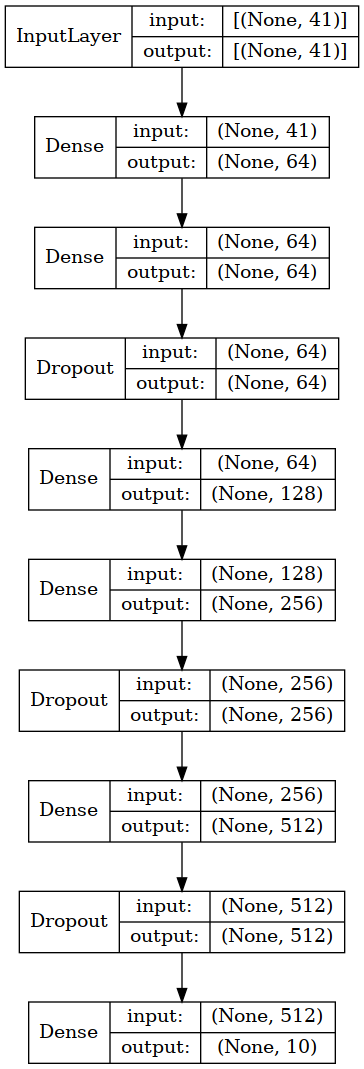

In [29]:
def get_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(df_family['Class'].nunique(), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = get_model(X_train.shape[1])

print(model.summary())
# tf.keras.utils.plot_model(model, show_shapes=True,show_layer_names=False,rankdir = 'LR')
# plot the model in a single line using tf.keras.utils.plot_model'
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)


In [30]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Compile and fit

In [31]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#validation accuracy chart



history = model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=1)
# history = model.fit(X_train, y_train, epochs=10, batch_size=10,validation_data=(X_val, y_val), verbose=1)



Epoch 1/100


16/16 [==============================] - 1s 9ms/step - loss: 2.0026 - accuracy: 0.3361
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 1.8297 - accuracy: 0.3593
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.7281 - accuracy: 0.3920
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.6298 - accuracy: 0.4284
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 1.5369 - accuracy: 0.4504
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 1.4446 - accuracy: 0.5050
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 1.4111 - accuracy: 0.5283
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 1.3347 - accuracy: 0.5540
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 1.3008 - accuracy: 0.5540
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2206 - accuracy: 0.5760
Epoch 11/100
16/16 [=

## Predict

In [34]:
y_pred_ann, y_pred_ann_class = predict_model(model,X_test, y_test, class_encoder,print_metric = True)
y_train_ann, y_train_ann_class = predict_model(model,X_train, y_train, class_encoder)

np.savetxt('./meta_data/y_pred_ann.csv', y_pred_ann, delimiter=',')
np.savetxt('./meta_data/y_train_ann.csv', y_train_ann, delimiter=',')

13/13 [==============================] - 0s 2ms/step


Accurary: 0.7368421052631579
50/50 [==============================] - 0s 2ms/step


## Graph

In [35]:
df_family['Class'].unique()

array(['Miscellaneous', 'Downloader', 'Ransomware', 'Trojan', 'Backdoor',
       'Infostealer', 'Loader', 'Botnet', 'ATM Malware', 'Dropper'],
      dtype=object)

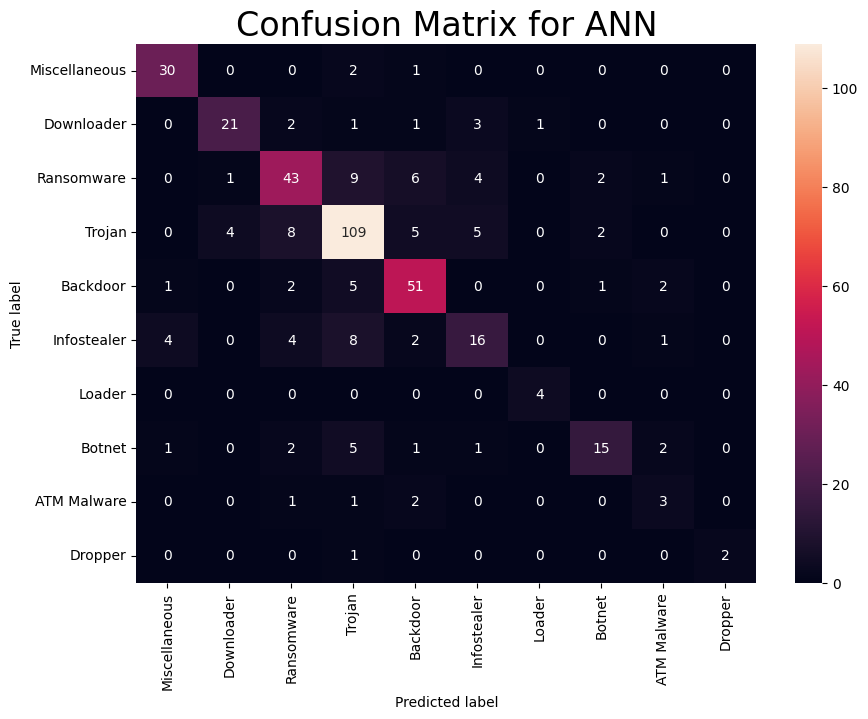

               precision    recall  f1-score   support

  ATM Malware       0.33      0.43      0.38         7
     Backdoor       0.74      0.82      0.78        62
       Botnet       0.75      0.56      0.64        27
   Downloader       0.81      0.72      0.76        29
      Dropper       1.00      0.67      0.80         3
  Infostealer       0.55      0.46      0.50        35
       Loader       0.80      1.00      0.89         4
Miscellaneous       0.83      0.91      0.87        33
   Ransomware       0.69      0.65      0.67        66
       Trojan       0.77      0.82      0.80       133

     accuracy                           0.74       399
    macro avg       0.73      0.70      0.71       399
 weighted avg       0.74      0.74      0.73       399



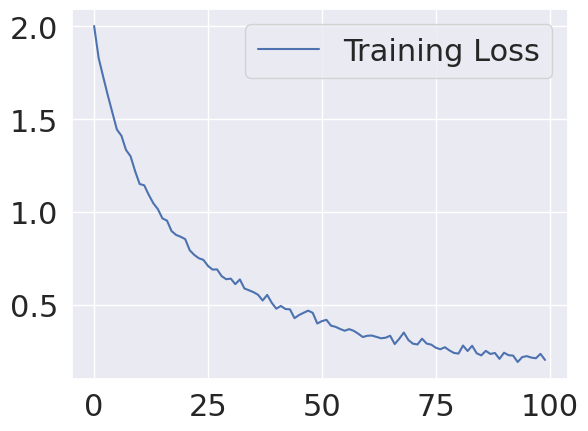

In [36]:
y_test_label = class_encoder.inverse_transform(y_test)
plotAll(y_test_label,y_pred_ann,y_pred_ann_class,history,df_family['Class'].unique(),"Confusion Matrix for ANN")

# 1D CNN

In [37]:
df_family['Class'].nunique()

10

In [25]:

def get_cnn_model(input_shape):
    input_shape = (input_shape, 1)

    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, strides = 2, kernel_regularizer=l2(0.01), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    model.add(Flatten())

    # fully connected layer
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(df_family['Class'].nunique(), activation='softmax'))

    # Compile the model
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

    # Print the model summary
    print(model.summary())

    return model

model_cnn =get_cnn_model(X_train.shape[1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 20, 128)           512       
                                                                 
 batch_normalization_6 (Bat  (None, 20, 128)           512       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 20, 128)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 10, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 256)           98560     
                                                                 
 batch_normalization_7 (Bat  (None, 10, 256)          

In [26]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=30, batch_size=128)


Epoch 1/30
13/13 [==============================] - 1s 19ms/step - loss: 3.9102 - accuracy: 0.2808
Epoch 2/30
13/13 [==============================] - 0s 18ms/step - loss: 3.6021 - accuracy: 0.3599
Epoch 3/30
13/13 [==============================] - 0s 16ms/step - loss: 3.5173 - accuracy: 0.3725
Epoch 4/30
13/13 [==============================] - 0s 19ms/step - loss: 3.4318 - accuracy: 0.3907
Epoch 5/30
13/13 [==============================] - 0s 18ms/step - loss: 3.4005 - accuracy: 0.4008
Epoch 6/30
13/13 [==============================] - 0s 18ms/step - loss: 3.3426 - accuracy: 0.4290
Epoch 7/30
13/13 [==============================] - 0s 17ms/step - loss: 3.2919 - accuracy: 0.4435
Epoch 8/30
13/13 [==============================] - 0s 17ms/step - loss: 3.2639 - accuracy: 0.4479
Epoch 9/30
13/13 [==============================] - 0s 16ms/step - loss: 3.2215 - accuracy: 0.4604
Epoch 10/30
13/13 [==============================] - 0s 16ms/step - loss: 3.1778 - accuracy: 0.4793
Epoch 11/

In [29]:
y_pred_1dcnn, y_pred_1dcnn_class = predict_model(model_cnn,X_test, y_test, class_encoder,print_metric = True)
y_train_1dcnn, y_train_1dcnn_class = predict_model(model_cnn,X_train, y_train, class_encoder)

np.savetxt('./meta_data/y_pred_1dcnn.csv', y_pred_1dcnn, delimiter=',')
np.savetxt('./meta_data/y_train_1dcnn.csv', y_train_1dcnn, delimiter=',')

13/13 [==============================] - 0s 4ms/step
Accurary: 0.5238095238095238
50/50 [==============================] - 0s 5ms/step


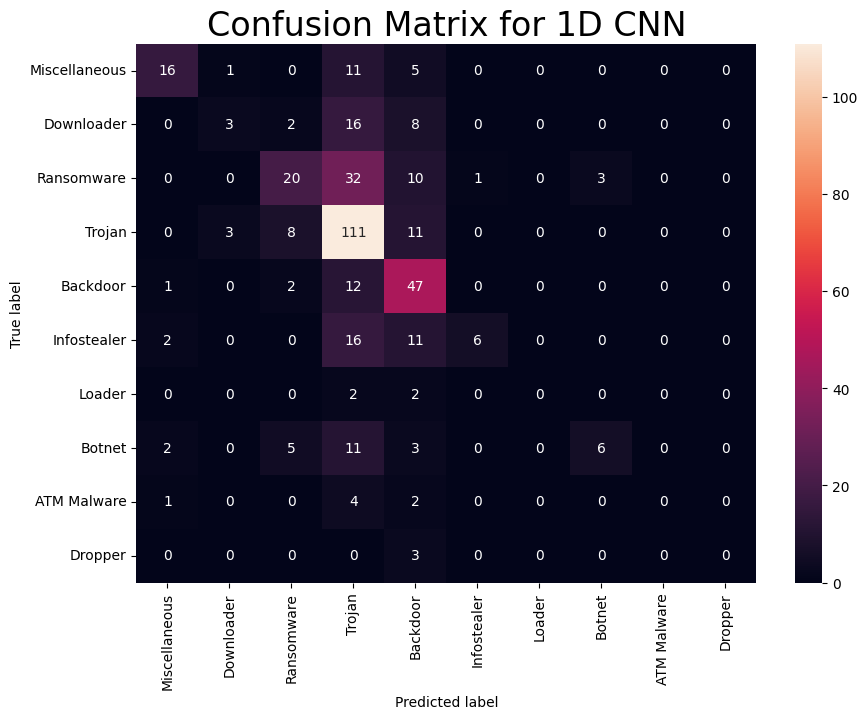

               precision    recall  f1-score   support

  ATM Malware       0.00      0.00      0.00         7
     Backdoor       0.46      0.76      0.57        62
       Botnet       0.67      0.22      0.33        27
   Downloader       0.43      0.10      0.17        29
      Dropper       0.00      0.00      0.00         3
  Infostealer       0.86      0.17      0.29        35
       Loader       0.00      0.00      0.00         4
Miscellaneous       0.73      0.48      0.58        33
   Ransomware       0.54      0.30      0.39        66
       Trojan       0.52      0.83      0.64       133

     accuracy                           0.52       399
    macro avg       0.42      0.29      0.30       399
 weighted avg       0.54      0.52      0.47       399



/home/sukhmeet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sukhmeet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sukhmeet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


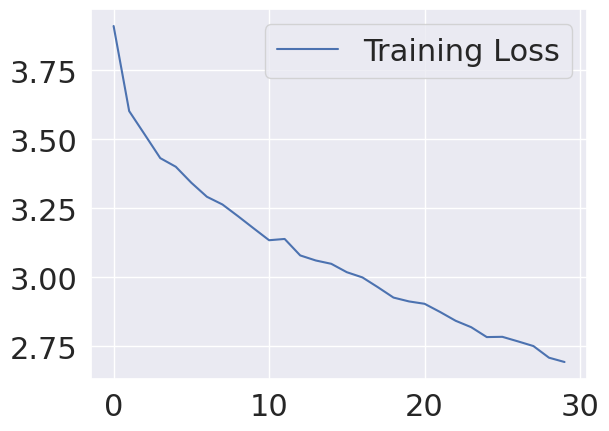

In [30]:
y_test_label = class_encoder.inverse_transform(y_test)
plotAll(y_test_label,y_pred_1dcnn,y_pred_1dcnn_class,history_cnn,df_family['Class'].unique(),"Confusion Matrix for 1D CNN")

# 2D CNN

In [70]:
def pad_and_reshape(x):
    # Calculate padding size
    pad_size = np.ceil(float(x.size) / 49).astype(int) * 49 - x.size
    # Apply padding
    x_padded = np.pad(x, (0, pad_size), 'constant')
    # Reshape
    return x_padded.reshape(7, 7)

X_train_cnn = X_train.apply(pad_and_reshape, axis=1)
X_train_cnn = np.stack(X_train_cnn)
X_test_cnn = X_test.apply(pad_and_reshape, axis=1)
X_test_cnn = np.stack(X_test_cnn)
try:
  X_val_cnn = X_val.apply(pad_and_reshape, axis=1)
  X_val_cnn = np.stack(X_val_cnn)
except:
  pass  

In [71]:
X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)

print("New training data shape:", X_train_cnn.shape)


New training data shape: (1592, 7, 7, 1)


In [74]:

def get_cnn_model(input_shape):
    input_shape = (input_shape[0],input_shape[1], 1)
    
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(2,2), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
    #Flatten
    model.add(Flatten())
    

    # fully connected layer
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(df_family['Class'].nunique(), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

    # Print the model summary
    print(model.summary())

    return model

model =get_cnn_model((X_train_cnn.shape[1],X_train_cnn.shape[2]))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 6, 6, 128)         640       
                                                                 
 batch_normalization_12 (Ba  (None, 6, 6, 128)         512       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 6, 6, 128)         0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1152)              0         
                                                                 
 dense_24 (Dense)            (None, 100)              

In [75]:
history = model.fit(X_train_cnn, y_train, epochs=30, batch_size=128, verbose=1)

Epoch 1/30
13/13 [==============================] - 1s 12ms/step - loss: 2.1691 - accuracy: 0.2758
Epoch 2/30
13/13 [==============================] - 0s 12ms/step - loss: 1.9440 - accuracy: 0.3266
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 1.8407 - accuracy: 0.3505
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 1.8159 - accuracy: 0.3649
Epoch 5/30
13/13 [==============================] - 0s 12ms/step - loss: 1.7652 - accuracy: 0.3737
Epoch 6/30
13/13 [==============================] - 0s 12ms/step - loss: 1.6909 - accuracy: 0.4045
Epoch 7/30
13/13 [==============================] - 0s 12ms/step - loss: 1.7080 - accuracy: 0.4108
Epoch 8/30
13/13 [==============================] - 0s 11ms/step - loss: 1.6864 - accuracy: 0.4052
Epoch 9/30
13/13 [==============================] - 0s 11ms/step - loss: 1.6256 - accuracy: 0.4114
Epoch 10/30
13/13 [==============================] - 0s 12ms/step - loss: 1.5924 - accuracy: 0.4416
Epoch 11/

In [79]:
y_pred_2dcnn, y_pred_2dcnn_class = predict_model(model,X_test_cnn, y_test, class_encoder,print_metric = True)
y_train_2dcnn, y_train_2dcnn_class = predict_model(model,X_train_cnn, y_train, class_encoder)

np.savetxt('./meta_data/y_pred_2dcnn.csv', y_pred_2dcnn, delimiter=',')
np.savetxt('./meta_data/y_train_2dcnn.csv', y_train_2dcnn, delimiter=',')

13/13 [==============================] - 0s 3ms/step


Accurary: 0.5714285714285714
50/50 [==============================] - 0s 3ms/step


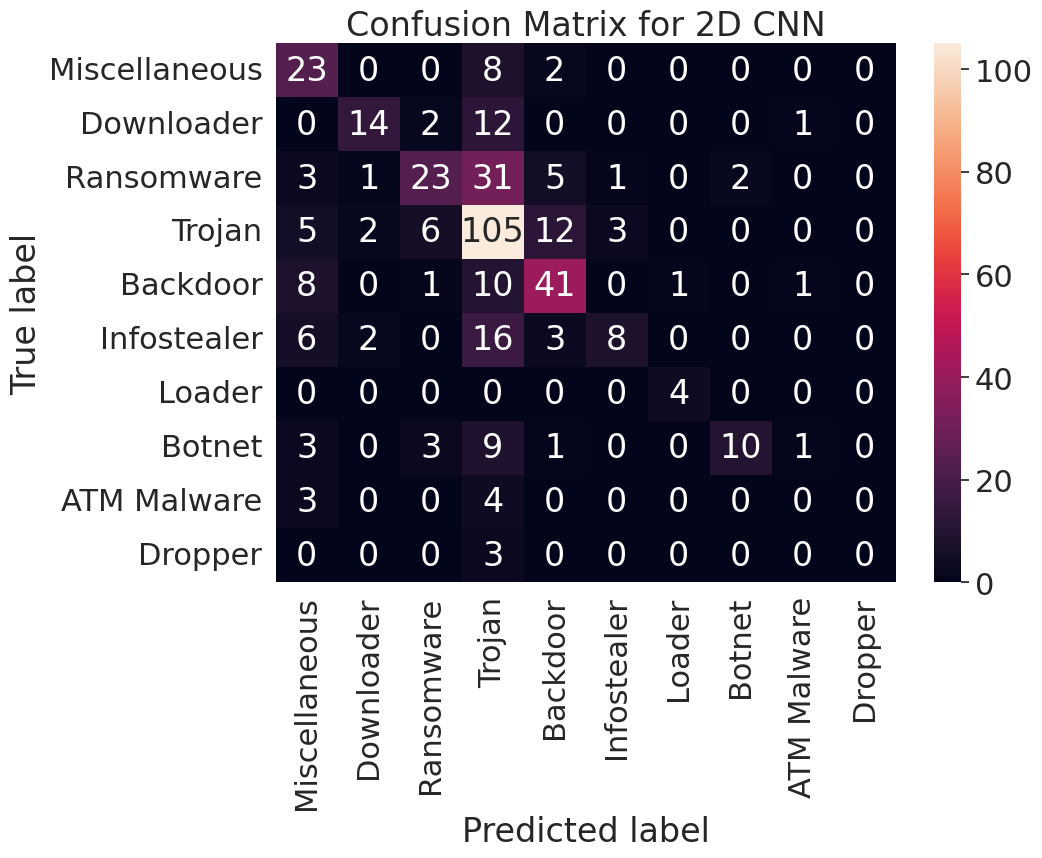

               precision    recall  f1-score   support

  ATM Malware       0.00      0.00      0.00         7
     Backdoor       0.64      0.66      0.65        62
       Botnet       0.83      0.37      0.51        27
   Downloader       0.74      0.48      0.58        29
      Dropper       0.00      0.00      0.00         3
  Infostealer       0.67      0.23      0.34        35
       Loader       0.80      1.00      0.89         4
Miscellaneous       0.45      0.70      0.55        33
   Ransomware       0.66      0.35      0.46        66
       Trojan       0.53      0.79      0.63       133

     accuracy                           0.57       399
    macro avg       0.53      0.46      0.46       399
 weighted avg       0.60      0.57      0.55       399



/home/sukhmeet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sukhmeet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sukhmeet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


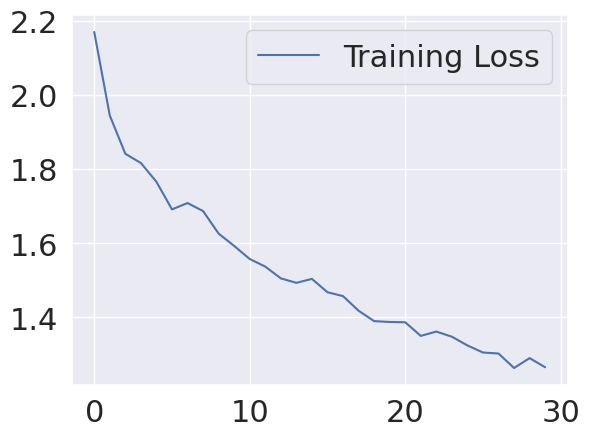

In [80]:
y_test_label = class_encoder.inverse_transform(y_test)
plotAll(y_test_label,y_pred_2dcnn,y_pred_2dcnn_class,history,df_family['Class'].unique(),"Confusion Matrix for 2D CNN")

# Heterogeneous Model

In [31]:
# load from file 

X_pred_ann = pd.read_csv('./meta_data/y_pred_ann.csv',header = None).values.flatten()
X_pred_cnn = pd.read_csv('./meta_data/y_pred_1dcnn.csv',header = None).values.flatten()
X_pred_cnn2d = pd.read_csv('./meta_data/y_pred_2dcnn.csv',header = None).values.flatten()

X_train_ann = pd.read_csv('./meta_data/y_train_ann.csv',header = None).values.flatten()
X_train_cnn = pd.read_csv('./meta_data/y_train_1dcnn.csv',header = None).values.flatten()
X_train_cnn2d = pd.read_csv('./meta_data/y_train_2dcnn.csv',header = None).values.flatten()


In [57]:
X_meta_test = pd.DataFrame({'X_pred_ann':X_pred_ann,'X_pred_cnn2d':X_pred_cnn2d,'X_pred_cnn':X_pred_cnn})
y_meta_test = y_test

X_meta_train = pd.DataFrame({'X_pred_ann':X_train_ann,'X_pred_cnn2d':X_train_cnn2d,'X_pred_cnn':X_train_cnn})
y_meta_train = y_train



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 4)                 16        
                                                                 
 dense_16 (Dense)            (None, 8)                 40        
                                                                 
 dense_17 (Dense)            (None, 10)                90        
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


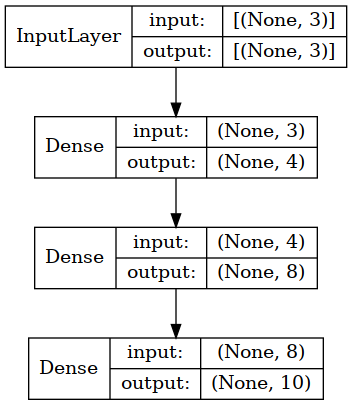

In [58]:




# create a model to stack the models
def get_meta_model(input_shape):
    model = Sequential()
    model.add(Dense(4, input_dim=input_shape, activation='relu'))
    model.add(Dense(8, activation='relu'))
    # model.add(Dense(100, activation='relu'))
    model.add(Dense(df_family['Class'].nunique(), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
  
model_meta = get_meta_model(X_meta_train.shape[1])



print(model_meta.summary())
tf.keras.utils.plot_model(model_meta, show_shapes=True,show_layer_names=False)




In [59]:
history_meta = model_meta.fit(X_meta_train, y_meta_train, epochs=30, batch_size=128, verbose=1)

Epoch 1/30
1/1 [==============================] - 0s 448ms/step - loss: 3.0108 - accuracy: 0.3807
Epoch 2/30
1/1 [==============================] - 0s 9ms/step - loss: 2.9858 - accuracy: 0.3518
Epoch 3/30
1/1 [==============================] - 0s 8ms/step - loss: 2.9612 - accuracy: 0.3518
Epoch 4/30
1/1 [==============================] - 0s 7ms/step - loss: 2.9369 - accuracy: 0.3518
Epoch 5/30
1/1 [==============================] - 0s 7ms/step - loss: 2.9129 - accuracy: 0.3518
Epoch 6/30
1/1 [==============================] - 0s 7ms/step - loss: 2.8892 - accuracy: 0.3518
Epoch 7/30
1/1 [==============================] - 0s 8ms/step - loss: 2.8658 - accuracy: 0.3518
Epoch 8/30
1/1 [==============================] - 0s 9ms/step - loss: 2.8428 - accuracy: 0.3518
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 2.8201 - accuracy: 0.3518
Epoch 10/30
1/1 [==============================] - 0s 7ms/step - loss: 2.7977 - accuracy: 0.3518
Epoch 11/30
1/1 [====================

In [60]:
y_pred_meta, y_pred_meta_class = predict_model(model,X_test, y_test, class_encoder,print_metric = True)
y_train_meta, y_train_meta_class = predict_model(model,X_train, y_train, class_encoder)

np.savetxt('./meta_data/y_pred_meta.csv', y_pred_meta, delimiter=',')
np.savetxt('./meta_data/y_train_meta.csv', y_train_meta, delimiter=',')

13/13 [==============================] - 0s 2ms/step
Accurary: 0.7393483709273183
50/50 [==============================] - 0s 2ms/step


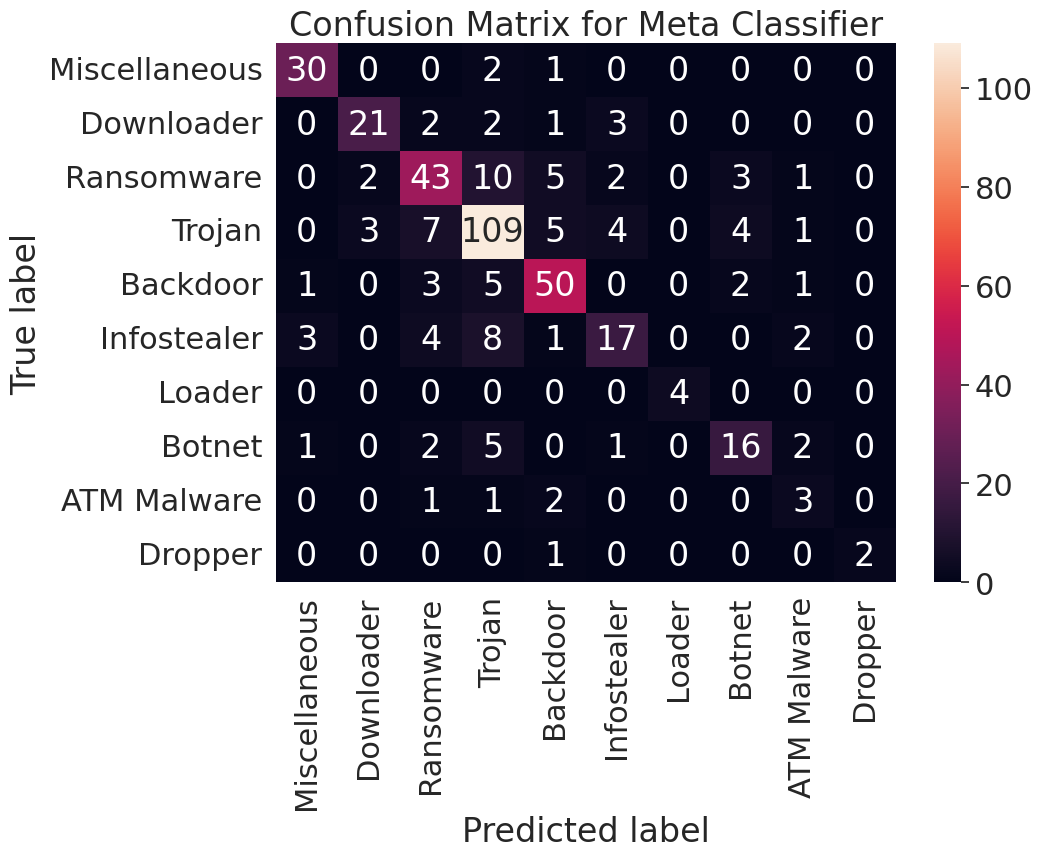

               precision    recall  f1-score   support

  ATM Malware       0.30      0.43      0.35         7
     Backdoor       0.76      0.81      0.78        62
       Botnet       0.64      0.59      0.62        27
   Downloader       0.81      0.72      0.76        29
      Dropper       1.00      0.67      0.80         3
  Infostealer       0.63      0.49      0.55        35
       Loader       1.00      1.00      1.00         4
Miscellaneous       0.86      0.91      0.88        33
   Ransomware       0.69      0.65      0.67        66
       Trojan       0.77      0.82      0.79       133

     accuracy                           0.74       399
    macro avg       0.75      0.71      0.72       399
 weighted avg       0.74      0.74      0.74       399



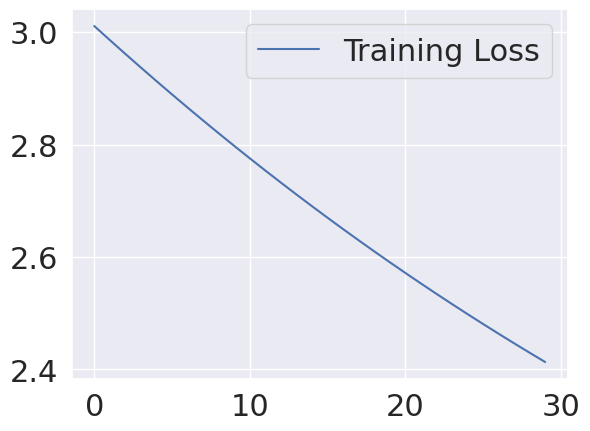

In [62]:
y_test_label = class_encoder.inverse_transform(y_test)
plotAll(y_test_label,y_pred_meta,y_pred_meta_class,history_meta,df_family['Class'].unique(),"Confusion Matrix for Meta Classifier")